# Markov matrix

Visualizing a Markov matrix.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_palette("Set2")
sns.set_style("whitegrid")

In [3]:
transition_mat = pd.read_pickle("Transition_USA.pickle")

In [4]:
df = transition_mat.div(transition_mat.Total, axis=0)
df = df[df.columns[:-1]]
df = df.round(2)

### Adjacency matrix

In [5]:
df

,A,B,C,D,E,F,G
A,0.85,0.14,0.00,0.00,0.02,0.00,0.00
B,0.01,0.87,0.11,0.01,0.00,0.00,0.00
C,0.00,0.01,0.92,0.07,0.00,0.00,0.00
D,0.00,0.00,0.02,0.94,0.04,0.00,0.00
E,0.00,0.00,0.00,0.05,0.94,0.01,0.00
F,0.00,0.00,0.00,0.00,0.11,0.88,0.00
G,0.00,0.00,0.00,0.00,0.01,0.01,0.98


### Adjacency list

In [6]:
graph = {}
for score in df.index:
    temp_d = {}
    for i, e in enumerate(df.ix[score]):
        if e != 0:
            temp_d[df.columns[i]] = e
    graph[score] = temp_d

graph

{'A': {'A': 0.84999999999999998, 'B': 0.14000000000000001, 'E': 0.02},
 'B': {'A': 0.01, 'B': 0.87, 'C': 0.11, 'D': 0.01},
 'C': {'B': 0.01, 'C': 0.92000000000000004, 'D': 0.070000000000000007},
 'D': {'C': 0.02, 'D': 0.93999999999999995, 'E': 0.040000000000000001},
 'E': {'D': 0.050000000000000003, 'E': 0.93999999999999995, 'F': 0.01},
 'F': {'E': 0.11, 'F': 0.88},
 'G': {'E': 0.01, 'F': 0.01, 'G': 0.97999999999999998}}

### Graph
From a graph, it's easy see to that some nodes don't have many neighbors (A, C, F and G) and that E is central.

In [7]:
DG = nx.MultiDiGraph()
for i in df.index:
    for j in df.columns:
        if df.loc[i, j] > 0:
            DG.add_weighted_edges_from([(i, j, df.loc[i, j])])

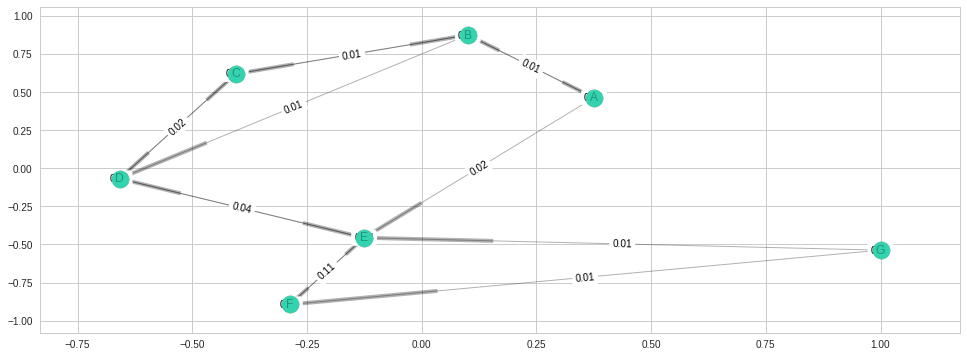

In [8]:
fig, ax = plt.subplots(figsize=(16.5, 6))

pos = nx.spring_layout(DG)
new_labels = dict(map(lambda x:((x[0],x[1]), str(x[2]['weight'] if x[2]['weight']<=3 else "") ), DG.edges(data = True)))
nx.draw_networkx(DG, pos=pos, alpha=.3)
nx.draw_networkx_nodes(DG, pos=pos, node_color="#33d3af")
nx.draw_networkx_edge_labels(DG, pos=pos, edge_labels = new_labels)
plt.show()

### Barplots
Barplots show more clearly maybe unexpected neighbors, such as A and E. Some odds are well communicated too (G's self-loop has the highest probability).

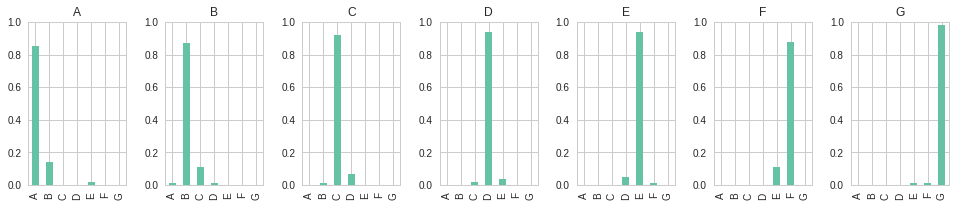

In [9]:
fig = plt.figure(figsize=(16.5, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 8):
    ax = fig.add_subplot(1, 7, i)
    df.ix[i - 1].plot(kind="bar", title=df.columns[i - 1])
    ax.set_ylim([0, 1])

### Inverse weights and Dijkstra's algorithm
I inverse weights to make shortest-path type of algorithms applicable to my graph.

In [10]:
{"path": nx.dijkstra_path(G=DG, source="B", target="E"),
"length": nx.dijkstra_path_length(G=DG, source="B", target="E")}

{'length': 0.029999999999999999, 'path': ['B', 'A', 'E']}

In [11]:
DG_inv = nx.MultiDiGraph()
for i in df.index:
    for j in df.columns:
        if df.loc[i, j] > 0:
            DG_inv.add_weighted_edges_from([(i, j, 1/df.loc[i, j])])

In [12]:
{"path": nx.dijkstra_path(G=DG_inv, source="B", target="E"),
"length": nx.dijkstra_path_length(G=DG_inv, source="B", target="E")}

{'length': 48.376623376623378, 'path': ['B', 'C', 'D', 'E']}

In [13]:
{"path": nx.dijkstra_path(G=DG_inv, source="A", target="E"),
"length": nx.dijkstra_path_length(G=DG_inv, source="A", target="E")}

{'length': 50.0, 'path': ['A', 'E']}

### Odds for t > 1
We can see that in the long-run, there is a stabilization around D and E.

In [14]:
#for A at t=2
names = df.columns
pd.DataFrame(
            np.linalg.matrix_power(np.matrix(df), 2),
            columns=names,
            index=names)

,A,B,C,D,E,F,G
A,0.7239,0.2408,0.0154,0.0024,0.0358,0.0002,0.0000
B,0.0172,0.7594,0.1971,0.0258,0.0006,0.0000,0.0000
C,0.0001,0.0179,0.8489,0.1303,0.0028,0.0000,0.0000
D,0.0000,0.0002,0.0372,0.8870,0.0752,0.0004,0.0000
E,0.0000,0.0000,0.0010,0.0940,0.8867,0.0182,0.0000
F,0.0000,0.0000,0.0000,0.0055,0.2002,0.7755,0.0000
G,0.0000,0.0000,0.0000,0.0005,0.0203,0.0187,0.9604


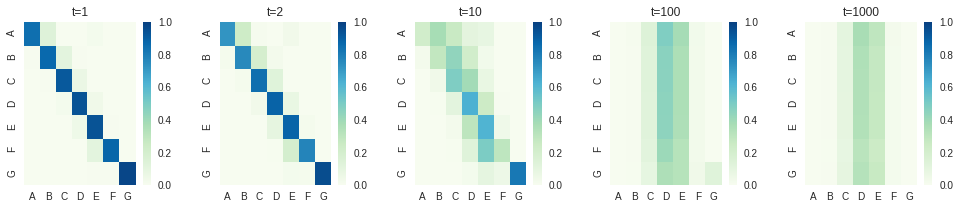

In [15]:
t = [1, 2, 10, 100, 1000]

fig = plt.figure(figsize=(16.5, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, e in enumerate(t):
    ax = fig.add_subplot(1, len(t), i + 1)
    sns.heatmap(
        pd.DataFrame(
            np.linalg.matrix_power(np.matrix(df), e),
            columns=names,
            index=names),
        vmin=0,
        vmax=1,
        cmap="GnBu")
    ax.set_title("t=%s" % str(e))